# <a id='toc1_'></a>[Visual Question Answering](#toc0_)

Visual Question Answering (VQA) is the task of answering open-ended questions based on an image. VQA has many applications: Medical VQA, Education purposes, for surveillance and numerous other applications. In this project we will use the VQA v2
 dataset for Visual Question Answering. This dataset was constructed to balance “yes/no” answers and reduce language priors that appeared in the first version of VQA.

In the words of the creators of VQA v2:
“Compared to VQA v1.0, the VQA v2.0 dataset is more balanced. For every question, there exist complementary images such that the answer to the question is different, which helps in reducing question–answer biases and encourages models to rely more on visual understanding.”

<p align="center"> <img src="Latex Paper\graphics\chapter1\minhhoa.png" alt="vqa_v2_example" width="500"/> </p>

## <a id='toc1_2_'></a>[Importing Libraries](#toc0_)

In [2]:
# Importing os, numpy and pandas for data manipulation
import os
import numpy as np 
import pandas as pd

# For data visualization, we will use matplotlib, wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For data preprocessing, we will use Counter, train_test_split, Levenshtein distance, Python Image Library and OneHotEncoder
from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# For saving and loading the preprocessed data, we will use pickle
import pickle

# For Building the model, we will use PyTorch and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader

# For taking the image from the URL, we will use requests
import requests

# For evaluation, we will need sklearn.metrics.average_precision_score
from sklearn.metrics import average_precision_score

# Importing json for results formatting which will be uploaded for evaluation
import json

## <a id='toc1_3_'></a>[Configuring the Notebook](#toc0_)

In [23]:

INPUT_PATH = r"E:\HK1  2025-2026\Đồ án CS420\VQA\Dataset\VQA V2"
OUTPUT_PATH = r"E:\HK1  2025-2026\Đồ án CS420\VQA\Output"

TRAIN_PATH = os.path.join(INPUT_PATH, "train2014", "train2014")
VALIDATION_PATH = os.path.join(INPUT_PATH, "val2014", "val2014")
ANNOTATIONS_TRAIN_PATH = os.path.join(INPUT_PATH, "v2_Annotations_Train_mscoco", "v2_mscoco_train2014_annotations.json")
ANNOTATIONS_VAL_PATH = os.path.join(INPUT_PATH, "v2_Annotations_Val_mscoco", "v2_mscoco_val2014_annotations.json")
QUESTIONS_TRAIN_PATH =  os.path.join(INPUT_PATH, "v2_Questions_Train_mscoco", "v2_OpenEnded_mscoco_train2014_questions.json")
QUESTIONS_VAL_PATH =  os.path.join(INPUT_PATH, "v2_Questions_Val_mscoco", "v2_OpenEnded_mscoco_val2014_questions.json")


ANSWER_SPACE = 0
MODEL_NAME = "ViT-L/14@336px"

# Check CUDA
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


CUDA available: True
Device: cuda
GPU Name: NVIDIA GeForce RTX 3060


## <a id='toc1_6_'></a>[Exploratory Data Analysis](#toc0_)

### <a id='toc1_6_1_'></a>[Load Dataframe](#toc0_)

In [15]:

# Load annotations
with open(ANNOTATIONS_TRAIN_PATH, "r") as f:
    ann_data = json.load(f)

annotations = ann_data["annotations"]
df_ann = pd.DataFrame(annotations)

# Load questions
with open(QUESTIONS_TRAIN_PATH, "r") as f:
    q_data = json.load(f)

questions = q_data["questions"]
df_q = pd.DataFrame(questions)

print(df_ann.head())
print(df_q.head())


       question_type multiple_choice_answer  \
0       what is this                    net   
1               what                pitcher   
2  what color is the                 orange   
3            is this                    yes   
4  what color is the                  white   

                                             answers  image_id answer_type  \
0  [{'answer': 'net', 'answer_confidence': 'maybe...    458752       other   
1  [{'answer': 'pitcher', 'answer_confidence': 'y...    458752       other   
2  [{'answer': 'orange', 'answer_confidence': 'ye...    458752       other   
3  [{'answer': 'yes', 'answer_confidence': 'yes',...    458752      yes/no   
4  [{'answer': 'white', 'answer_confidence': 'yes...    262146       other   

   question_id  
0    458752000  
1    458752001  
2    458752002  
3    458752003  
4    262146000  
   image_id                                     question  question_id
0    458752    What is this photo taken looking through?    458752000
1    4


### <a id='toc1_6_1_'></a>[Merge Dataset (Question + Annotation)](#toc0_)

In [16]:
df = pd.merge(df_q, df_ann, on=["question_id", "image_id"])
print(df.head())

   image_id                                     question  question_id  \
0    458752    What is this photo taken looking through?    458752000   
1    458752           What position is this man playing?    458752001   
2    458752             What color is the players shirt?    458752002   
3    458752  Is this man a professional baseball player?    458752003   
4    262146                      What color is the snow?    262146000   

       question_type multiple_choice_answer  \
0       what is this                    net   
1               what                pitcher   
2  what color is the                 orange   
3            is this                    yes   
4  what color is the                  white   

                                             answers answer_type  
0  [{'answer': 'net', 'answer_confidence': 'maybe...       other  
1  [{'answer': 'pitcher', 'answer_confidence': 'y...       other  
2  [{'answer': 'orange', 'answer_confidence': 'ye...       other  
3  [{'answ

### <a id='toc1_6_1_'></a>[Descriptive Statistics](#toc0_)

In [17]:
print("Số câu hỏi:", len(df))
print("Số ảnh:", df["image_id"].nunique())
print("Số câu trả lời duy nhất:", df["multiple_choice_answer"].nunique())


Số câu hỏi: 443757
Số ảnh: 82783
Số câu trả lời duy nhất: 22531


In [19]:
print(df["multiple_choice_answer"].value_counts().head(20))

multiple_choice_answer
yes         84978
no          82516
1           12540
2           12215
white        8916
3            6536
blue         5455
red          5201
black        5066
0            4977
4            4118
brown        3814
green        3750
yellow       2792
5            2367
gray         2113
nothing      1814
right        1766
frisbee      1641
baseball     1597
Name: count, dtype: int64


<Axes: xlabel='question_type'>

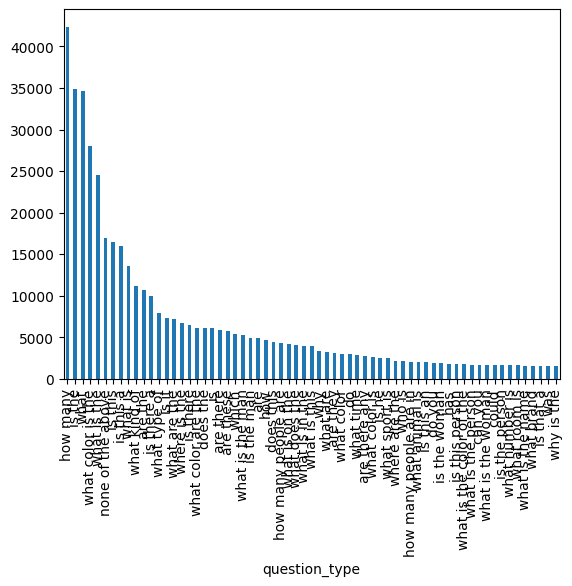

In [20]:
df["question_type"].value_counts().plot(kind="bar")


Độ dài trung bình câu hỏi: 6.2015427362272595
Độ dài lớn nhất: 22
Độ dài nhỏ nhất: 2


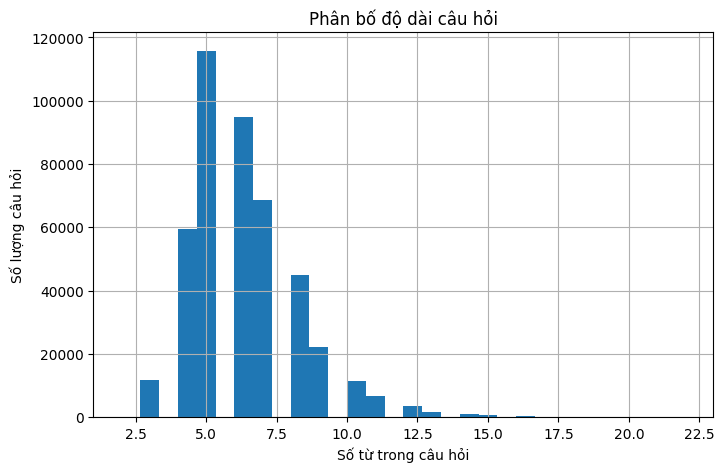

In [21]:
df["q_len"] = df["question"].str.split().str.len()

print("Độ dài trung bình câu hỏi:", df["q_len"].mean())
print("Độ dài lớn nhất:", df["q_len"].max())
print("Độ dài nhỏ nhất:", df["q_len"].min())

# Histogram
plt.figure(figsize=(8,5))
df["q_len"].hist(bins=30)
plt.title("Phân bố độ dài câu hỏi")
plt.xlabel("Số từ trong câu hỏi")
plt.ylabel("Số lượng câu hỏi")
plt.show()

## <a id='toc1_7_'></a>[Processing Images & Questions using CLIP model](#toc0_)

Instead of lazy processing of images and questions embeddings and recomputing them over and over during forward passes in the model, we can preprocess them and save them in a file using Pickle. This will save us a lot of time when we want to train our model and decrease the time taken by one epoch drastically.

In [34]:

def read_dataframe(annotation_path, question_path, dataset_type="train"):
    """
    Reads VQA v2 annotation & question JSONs and returns a DataFrame with
    columns: image, question, answers, answer_type, multiple_choice_answer
    """
    # Load annotations
    with open(annotation_path, "r") as f:
        ann_data = json.load(f)
    df_ann = pd.DataFrame(ann_data["annotations"])
    
    # Load questions
    with open(question_path, "r") as f:
        q_data = json.load(f)
    df_q = pd.DataFrame(q_data["questions"])
    
    # Merge question + annotation
    df = pd.merge(df_q, df_ann, on=["question_id", "image_id"])
    
    # Tạo cột 'image' từ image_id
    prefix = "COCO_train2014_" if dataset_type=="train" else "COCO_val2014_"
    df["image"] = df["image_id"].apply(lambda x: f"{prefix}{x:012d}.jpg")
    
    # Optional: tạo 'answerable' nếu muốn
    df["answerable"] = df["multiple_choice_answer"].notnull()
    
    # Chọn các cột cần thiết
    df = df[["image_id", "image", "question", "answers", "answer_type", "multiple_choice_answer", "answerable"]]
    
    return df

def process_images(dataframe, image_path, clip_model, preprocessor, device, prefix="COCO_train2014_"):
    images = []
    with torch.no_grad():
        for _, row in dataframe.iterrows():
            filename = f"{prefix}{row['image_id']:012d}.jpg"
            full_path = os.path.join(image_path, filename)
            
            image = Image.open(full_path).convert("RGB")
            image = preprocessor(image).unsqueeze(0).to(device)
            
            image_features = clip_model.encode_image(image)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)  # normalize
            images.append(image_features.cpu())
    return torch.cat(images, dim=0)
def process_questions(dataframe, clip_model, device, batch_size=64):
    all_features = []
    questions = dataframe["question"].tolist()
    
    with torch.no_grad():
        for i in range(0, len(questions), batch_size):
            batch = questions[i:i+batch_size]
            tokens = clip.tokenize(batch).to(device)
            text_features = clip_model.encode_text(tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)  # normalize
            all_features.append(text_features.cpu())
    
    return torch.cat(all_features, dim=0)


In [35]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH, QUESTIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH, QUESTIONS_VAL_PATH)

# Split train → train + small test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(train_df, test_size=0.05, random_state=42, shuffle=True)

# Xác định số lượng câu trả lời duy nhất
ANSWER_SPACE = train_df["multiple_choice_answer"].nunique()
print("Number of distinct answers: ", ANSWER_SPACE)


Number of distinct answers:  21834


In [36]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH, QUESTIONS_TRAIN_PATH, dataset_type="train")
val_df   = read_dataframe(ANNOTATIONS_VAL_PATH, QUESTIONS_VAL_PATH, dataset_type="val")

# 2. Encode Images
train_images = process_images(train_df, TRAIN_PATH, clip_model, preprocessor, DEVICE, prefix="COCO_train2014_")
val_images   = process_images(val_df, VALIDATION_PATH, clip_model, preprocessor, DEVICE, prefix="COCO_val2014_")

# 3. Encode Questions
train_questions = process_questions(train_df, clip_model, DEVICE, batch_size=64)
val_questions   = process_questions(val_df, clip_model, DEVICE, batch_size=64)

KeyboardInterrupt: 

In [31]:
clip_model, preprocessor = clip.load(MODEL_NAME, device=DEVICE)
clip_model.eval().requires_grad_(False)

training_images = process_images(train_df, TRAIN_PATH, clip_model, preprocessor, DEVICE, prefix="COCO_train2014_")
training_questions = process_questions(train_df, clip_model, DEVICE, batch_size=64)

with open(OUTPUT_PATH + 'training_images.pkl', 'wb') as f:
    pickle.dump(training_images, f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'wb') as f:
    pickle.dump(training_questions, f)

validation_images = process_images(validation_df, VALIDATION_PATH, clip_model, preprocessor, DEVICE)
validation_questions = process_questions(validation_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'validation_images.pkl', 'wb') as f:
    pickle.dump(validation_images, f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'wb') as f:
    pickle.dump(validation_questions, f)

test_images = process_images(test_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
test_questions = process_questions(test_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'test_images.pkl', 'wb') as f:  
    pickle.dump(test_images, f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'wb') as f:
    pickle.dump(test_questions, f)

KeyError: 'image_id'